# Import packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from sklearn.svm import SVC
from scipy.ndimage.measurements import label
import numpy as np
import glob
import cv2
%matplotlib inline

# Features 

### Spatial binning

In [2]:
def bin_spatial(img, size=(32,32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

### Color histogram

In [3]:
def color_hist(img, nbins=32):
    # Compute the histograms of the color channels separately
    ch1_hist = np.histogram(img[:,:,0], bins=nbins, range=(0,256))
    ch2_hist = np.histogram(img[:,:,1], bins=nbins, range=(0,256))
    ch3_hist = np.histogram(img[:,:,2], bins=nbins, range=(0,256))
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((ch1_hist[0], ch2_hist[0], ch3_hist[0]))
    return hist_features

### Hog features

In [4]:
def get_hog_features(img, feature_vec=True, orient=11, pix_per_cell=14, cell_per_block=2):   
    features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), block_norm='L2-Hys', transform_sqrt=True, visualize=False, feature_vector=feature_vec)
    return features

### Extract features

In [5]:
def extract_features(imgs):
    features = []

    for file in imgs:
        file_features = []
        image = mpimg.imread(file)
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb) 
        
        # Spatial binning
        spatial_features = bin_spatial(feature_image)
        file_features.append(spatial_features)
        
        # Color histograms
        hist_features = color_hist(feature_image)
        file_features.append(hist_features)
        
        # Hog features for all channels
        hog_features = []
        
        for ch in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,ch]))
            
        hog_features = np.ravel(hog_features)        
        file_features.append(hog_features)
        
        # Append combined features
        features.append(np.concatenate(file_features))
        
    return features

# Classifier

### Read in datasets and extract feature vectors

In [6]:
# Read in dataset
cars = glob.glob('vehicles/*/*.png')
not_cars = glob.glob('non-vehicles/*/*.png')

# Extract feature vectors
car_features = extract_features(cars)
not_car_features = extract_features(not_cars)

# Combine car and not car
X = np.vstack((car_features, not_car_features)).astype(np.float64)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(not_car_features))))

### Split and normalize datasets

In [7]:
# Split 80/20 for train/test sets
rand_state = np.random.randint(0,100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state, shuffle=True)

# Normalize data
X_scaler = StandardScaler().fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

### Train classifier

In [8]:
clf = SVC(C=100, verbose=True)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

[LibSVM]0.995777027027027


# Detecting cars

### Find cars

In [9]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient=11, pix_per_cell=14, cell_per_block=2): 
    img = img.astype(np.float32)/255
    img = img[ystart:ystop,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    img = cv2.resize(img, (np.int(img.shape[1]/scale), np.int(img.shape[0]/scale)))
        
    ch1 = img[:,:,0]
    ch2 = img[:,:,1]
    ch3 = img[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for entire image
    hog1 = get_hog_features(ch1, feature_vec=False)
    hog2 = get_hog_features(ch2, feature_vec=False)
    hog3 = get_hog_features(ch3, feature_vec=False)
    
    boxes = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(img[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg)
            hist_features = color_hist(subimg)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)) 
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return boxes

### Add heat

In [10]:
def add_heat(heatmap, boxes):
    for box in boxes:
        # Add 1 for all pixels inside each box
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    return heatmap

### Draw boxes

In [11]:
def draw_boxes(img, labels):
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Define a bounding box based on min/max x and y
        box = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, box[0], box[1], (0,0,255), 6)
        
    return img

# Pipeline

### Regions and scale sizes to search

In [12]:
ystarts = [388, 400, 416, 400, 416, 432, 400, 432, 400, 464]
ystops = [452, 464, 480, 496, 512, 528, 528, 560, 596, 660]
scales = [1.0, 1.0, 1.0, 1.5, 1.5, 1.5, 2.0, 2.0, 3.5, 3.5]

### Process image

In [13]:
def process_image(img):
    boxes = []
    
    # Get all detected boxes from all searches
    for ystart, ystop, scale in zip(ystarts, ystops, scales):
        boxes += find_cars(img, ystart, ystop, scale, clf, X_scaler)
    
    # Create heatmap
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, boxes)
    heat = apply_threshold(heat, 1)
    heatmap = np.clip(heat, 0, 255)
    
    # Identify and draw blobs from heatmap
    labels = label(heatmap)
    draw_img = draw_boxes(np.copy(img), labels)
    return draw_img

### Test images

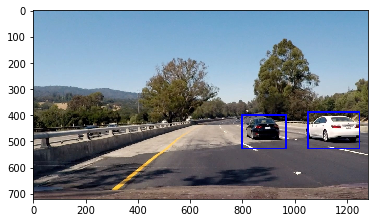

In [14]:
img = mpimg.imread('test_images/test4.jpg')
draw_img = process_image(img)
plt.imshow(draw_img)

### Test videos 

In [15]:
clip = VideoFileClip('project_video.mp4')
out_clip = clip.fl_image(process_image)
%time out_clip.write_videofile('output.mp4', audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|███████████████████████████████████▉| 1260/1261 [1:09:14<00:03,  3.30s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

Wall time: 1h 9min 15s
